## Book Revenue Pipeline - EDA & Transformation

วิเคราะห์ข้อมูลยอดขายหนังสือจากไฟล์ CSV ด้วย PySpark เพื่อเตรียมข้อมูลสำหรับนำไปใช้ในขั้นตอนถัดไปของ data pipeline เช่น การโหลดลง data warehouse หรือการทำ dashboard

### 1. Initialize Spark Session

- สร้าง SparkSession เพื่อใช้ประมวลผลข้อมูลด้วย PySpark

- ใช้ Spark อ่านจาก MySQL โดยตรงผ่าน JDBC ถ้าเป็น data ที่มาก เร็วกว่าและมีประสิทธิภาพกว่า

💡 ข้อควรระวัง

- ถ้าข้อมูลเยอะมาก (> หลายล้านแถว) การดึงด้วย PyMySQL แบบปกติอาจช้าและใช้หน่วยความจำเยอะ

- กรณีข้อมูลใหญ่ แนะนำใช้ Spark อ่านจาก MySQL ผ่าน JDBC โดยตรง

In [13]:
jar_path = "E:\Personal_Data\DataTH\Project\Book-Revenue-Pipeline-GCP\jars\mysql-connector-j-9.4.0.jar"

In [14]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
  .appName("Book_Revenue_Pipeline") \
  .config("spark.jars", jar_path) \
  .getOrCreate()

In [15]:
print(spark.sparkContext._conf.get("spark.jars"))

E:\Personal_Data\DataTH\Project\Book-Revenue-Pipeline-GCP\jars\mysql-connector-j-9.4.0.jar


### 2. Load Raw Data

In [17]:
df = spark.read.format("jdbc") \
    .option("url", "jdbc:mysql://localhost:3307/airflow_db") \
    .option("dbtable", "data_audible") \
    .option("user", "root") \
    .option("password", "rootpass") \
    .option("driver", "com.mysql.cj.jdbc.Driver") \
    .load()


- โหลดข้อมูลจาก Database ผ่าน JDBC ( Java Database Connectivity )

In [11]:
# อ่านข้อมูลจาก MySQL
df = spark.read.format("jdbc").options(
    url="jdbc:mysql://localhost:3307/airflow_db",  # พอร์ตตาม config
    driver="com.mysql.cj.jdbc.Driver",
    dbtable="data_audible",  # ชื่อตารางใน MySQL
    user="root",
    password="rootpass"
).load()

In [18]:
# บันทึก raw data
df.write.mode("overwrite").option("header", True).csv("../data/raw/database/raw_audible_data.csv")

- โหลดข้อมูลจาก API

In [ ]:
import requests
import pandas as pd
import json

url = "http://localhost:3000/conversion_rates"

# ดึงข้อมูลจาก API
response = requests.get(url)
result_data = response.json() # แปลงจาก json เป็น object

# บันทึกแบบ newline-delimited JSON (Spark format)
with open("../data/raw/database/conversion_rates.json", "w") as f:
    for row in result_data:
        f.write(json.dumps(row) + "\n")

In [ ]:
# อ่านข้อมูลจาก json โดยใช้ spark
df_conversion_rates = spark.read.json("../data/raw/database/conversion_rates.json")

In [7]:
df_conversion_rates.printSchema()
df_conversion_rates.show(5)

root
 |-- conversion_rate: double (nullable = true)
 |-- date: string (nullable = true)
 |-- id: string (nullable = true)

+---------------+----------+----+
|conversion_rate|      date|  id|
+---------------+----------+----+
|         31.194|2021-04-01|dc1b|
|          31.29|2021-04-02|ac7a|
|         31.256|2021-04-03|b741|
|         31.244|2021-04-04|eaa3|
|         31.342|2021-04-05|7caa|
+---------------+----------+----+
only showing top 5 rows



### 3. Initial Data Exploration and Exploratory Data Analysis (EDA)

  ##### 3.1 Data Profiling

- ดู schema และตัวอย่างข้อมูลเพื่อตรวจสอบว่า column มีชนิดข้อมูลถูกต้องหรือไม่

In [8]:
df.printSchema() # แสดงรายละเอียด Schema
df.show(5) # แสดงตาราง
print("Row :", df.count())

root
 |-- timestamp: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- book_id: string (nullable = true)
 |-- country: string (nullable = true)
 |-- Book Title: string (nullable = true)
 |-- Book Subtitle: string (nullable = true)
 |-- Book Author: string (nullable = true)
 |-- Book Narrator: string (nullable = true)
 |-- Audio Runtime: string (nullable = true)
 |-- Audiobook_Type: string (nullable = true)
 |-- Categories: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Total No. of Rating: string (nullable = true)
 |-- Price: string (nullable = true)

+-------------+--------+-------+--------------------+--------------------+--------------------+-------------+---------------+------------------+--------------------+--------------------+------+-------------------+---------+
|    timestamp| user_id|book_id|             country|          Book Title|       Book Subtitle|  Book Author|  Book Narrator|     Audio Runtime|      Audiobook_Type|          Cat

##### 3.2 Missing Values

- ตรวจสอบว่าคอลัมน์ใดมี missing/null values ที่อาจต้องจัดการ

- `null` — คือค่าที่ “ไม่มีข้อมูล” หรือ “ว่าง” ใช้ได้กับทุกชนิดข้อมูล (string, number, date, ฯลฯ)

- `NaN` — เป็นค่าพิเศษที่เกิดกับข้อมูลตัวเลข (float, double) แสดงว่า “ค่าไม่ใช่ตัวเลข” ค่าที่ข้อมูลเสียหาย

1.กรณีที่มี data type เป็น string ทั้งหมดหาค่า Missing Value

📌 คำอธิบาย
- `isNull()`: เช็กค่าที่เป็น null จริง

- `trim(col(c)) == ""`: เช็กค่าว่าง (`''` หรือ `' '`)

- `lower(trim(col(c))) == "null"`: กรณีเขียนว่า `"null"` (เป็น string)

In [9]:
from pyspark.sql.functions import col, when, count, trim, lower

df.select([
    count(
        when(
            col(f"`{c}`").isNull() | # f"`{c}`" แบบนี้เพราะชื่อ col มีการใช้ . หรือ ช่องว่าง 
            (trim(col(f"`{c}`")) == "") | 
            (lower(trim(col(f"`{c}`"))) == "null"),c
        )
    ).alias(c)
    for c in df.columns
]).show(truncate=False)

+---------+-------+-------+-------+----------+-------------+-----------+-------------+-------------+--------------+----------+------+-------------------+-----+
|timestamp|user_id|book_id|country|Book Title|Book Subtitle|Book Author|Book Narrator|Audio Runtime|Audiobook_Type|Categories|Rating|Total No. of Rating|Price|
+---------+-------+-------+-------+----------+-------------+-----------+-------------+-------------+--------------+----------+------+-------------------+-----+
|0        |0      |0      |0      |0         |406453       |0          |1891         |0            |2113          |11740     |7697  |9588               |0    |
+---------+-------+-------+-------+----------+-------------+-----------+-------------+-------------+--------------+----------+------+-------------------+-----+



2.กรณีที่มี data type มี float, double อยู่ด้วยต้องหา `null` และ `NaN` ให้ใช้แบบนี้ 

In [10]:
from pyspark.sql.functions import col, isnan, count, when
from pyspark.sql.types import FloatType, DoubleType, NumericType

# นับจำนวนหาค่า null และ NaN
def count_missing(df):
    exprs = []
    for c, dtype in df.dtypes:
        if dtype in ('float', 'double'):
            expr = count(when(col(f"`{c}`").isNull() | isnan(col(f"`{c}`")), c)).alias(c)
        else:
            expr = count(when(col(f"`{c}`").isNull(), c)).alias(c)
        exprs.append(expr)
    return df.select(exprs)

count_missing(df).show()


+---------+-------+-------+-------+----------+-------------+-----------+-------------+-------------+--------------+----------+------+-------------------+-----+
|timestamp|user_id|book_id|country|Book Title|Book Subtitle|Book Author|Book Narrator|Audio Runtime|Audiobook_Type|Categories|Rating|Total No. of Rating|Price|
+---------+-------+-------+-------+----------+-------------+-----------+-------------+-------------+--------------+----------+------+-------------------+-----+
|        0|      0|      0|      0|         0|            0|          0|            0|            0|             0|         0|     0|                  0|    0|
+---------+-------+-------+-------+----------+-------------+-----------+-------------+-------------+--------------+----------+------+-------------------+-----+



##### ❌กรณีที่เจอค่า null

##### ✅ เช็กทุกแถวที่มี null

In [11]:
from functools import reduce
from pyspark.sql.functions import col

# สร้าง filter สำหรับทุก column
null_filter = [col(f"`{c}`").isNull() | 
               (trim(col(f"`{c}`")) == "") |
               (lower(trim(col(f"`{c}`"))) == "null")
               for c in df.columns]
df.filter(reduce(lambda a, b: a | b, null_filter)).show(5)

+-------------+--------+-------+---------------+--------------------+-------------+-----------------+---------------+------------------+--------------------+--------------------+------+-------------------+---------+
|    timestamp| user_id|book_id|        country|          Book Title|Book Subtitle|      Book Author|  Book Narrator|     Audio Runtime|      Audiobook_Type|          Categories|Rating|Total No. of Rating|    Price|
+-------------+--------+-------+---------------+--------------------+-------------+-----------------+---------------+------------------+--------------------+--------------------+------+-------------------+---------+
|1/5/2021 0:00|ad8eca41|   1584|       Portugal|        Sycamore Row|             |     John Grisham|   Michael Beck|20 hrs and 46 mins|Unabridged Audiobook|Mystery, Thriller...|   4.6|              25863|$35.00 \r|
|1/5/2021 0:00|4f218413|   1586|         Taiwan|  How to Be a 3% Man|             |      Corey Wayne|    Corey Wayne| 7 hrs and 33 mins|

##### ดังนั้นเวลาตรวจสอบข้อมูล

- เราเช็คชนิดข้อมูล (dtype) ของแต่ละคอลัมน์

- สำหรับ string หรือชนิดอื่น ๆ ที่ไม่ใช่ตัวเลข → เช็คแค่ `null` ก็พอ

- สำหรับ ตัวเลข (float, double) → ควรเช็คทั้ง `null` และ `NaN` เพื่อครอบคลุมทุกกรณี


### 4. Data Cleaning

- การทำความสะอาดข้อมูล

##### 4.1 Convert Data Types

- แปลง data type ของ column เปลี่ยนชนิดข้อมูลให้ถูกต้อง

In [12]:
df.printSchema()

root
 |-- timestamp: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- book_id: string (nullable = true)
 |-- country: string (nullable = true)
 |-- Book Title: string (nullable = true)
 |-- Book Subtitle: string (nullable = true)
 |-- Book Author: string (nullable = true)
 |-- Book Narrator: string (nullable = true)
 |-- Audio Runtime: string (nullable = true)
 |-- Audiobook_Type: string (nullable = true)
 |-- Categories: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Total No. of Rating: string (nullable = true)
 |-- Price: string (nullable = true)



- แปลง `timestamp` เป็น type date และ data type ของ col อื่นๆ

In [13]:
from pyspark.sql.functions import to_timestamp, col, to_date
from pyspark.sql.types import FloatType, IntegerType, DoubleType

df_converted_types = (df.withColumn("timestamp", to_timestamp("timestamp", "d/M/yyyy H:mm"))
                        .withColumn("book_id", col("book_id").cast(IntegerType()))
                        .withColumn("rating", col("Rating").cast(DoubleType()))
                        .withColumnRenamed("Total No. of Rating", "total_rating_count")
                        .withColumn("total_rating_count", col("total_rating_count").cast(IntegerType()))
                        .withColumn("date", to_date(col("timestamp")))  # ⬅️ เพิ่มตรงนี้
                      )

In [14]:
df_converted_types.printSchema()

root
 |-- timestamp: timestamp (nullable = true)
 |-- user_id: string (nullable = true)
 |-- book_id: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- Book Title: string (nullable = true)
 |-- Book Subtitle: string (nullable = true)
 |-- Book Author: string (nullable = true)
 |-- Book Narrator: string (nullable = true)
 |-- Audio Runtime: string (nullable = true)
 |-- Audiobook_Type: string (nullable = true)
 |-- Categories: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- total_rating_count: integer (nullable = true)
 |-- Price: string (nullable = true)
 |-- date: date (nullable = true)



✅ คำอธิบาย:

- เปลี่ยน col ให้อยู่ในรูปแบบที่ถูกต้อง

- เปลี่ยนชื่อ col เป็น snake case และ ตัวเล็ก *

- สร้าง col ใหม่ชื่อ date ใช้สำหรับการ join table

In [15]:
df_converted_types.show(5)

+-------------------+--------+-------+--------------------+--------------------+--------------------+-------------+---------------+------------------+--------------------+--------------------+------+------------------+---------+----------+
|          timestamp| user_id|book_id|             country|          Book Title|       Book Subtitle|  Book Author|  Book Narrator|     Audio Runtime|      Audiobook_Type|          Categories|rating|total_rating_count|    Price|      date|
+-------------------+--------+-------+--------------------+--------------------+--------------------+-------------+---------------+------------------+--------------------+--------------------+------+------------------+---------+----------+
|2021-05-01 00:00:00|ad8eca41|   1584|            Portugal|        Sycamore Row|                    | John Grisham|   Michael Beck|20 hrs and 46 mins|Unabridged Audiobook|Mystery, Thriller...|   4.6|             25863|$35.00 \r|2021-05-01|
|2021-05-01 00:00:00|561b26c1|    829|Un

- แปลง `order_date` จาก Type String เป็น Date Type แล้ว

แปลง data type ของ `conversion_rates`

In [ ]:
from pyspark.sql.functions import to_date

df_conversion_rates = (df_conversion_rates.withColumn("date", to_date(col("date"))))

In [17]:
df_conversion_rates.printSchema()
df_conversion_rates.show(5)

root
 |-- conversion_rate: double (nullable = true)
 |-- date: date (nullable = true)
 |-- id: string (nullable = true)

+---------------+----------+----+
|conversion_rate|      date|  id|
+---------------+----------+----+
|         31.194|2021-04-01|dc1b|
|          31.29|2021-04-02|ac7a|
|         31.256|2021-04-03|b741|
|         31.244|2021-04-04|eaa3|
|         31.342|2021-04-05|7caa|
+---------------+----------+----+
only showing top 5 rows



In [18]:
from pyspark.sql.functions import col

df_conversion_rates.filter(col("date") == "2021-04-01").show()

+---------------+----------+----+
|conversion_rate|      date|  id|
+---------------+----------+----+
|         31.194|2021-04-01|dc1b|
+---------------+----------+----+



In [19]:
df_conversion_rates.filter(df_conversion_rates.conversion_rate == "31.14").show()

+---------------+----------+----+
|conversion_rate|      date|  id|
+---------------+----------+----+
|          31.14|2021-05-01|2055|
|          31.14|2021-06-10|a097|
+---------------+----------+----+



รวม table ของ `df_conversion_rates` และ `df_converted_types`

In [20]:
# join 2 dataframe
df_joined = df_converted_types.join(df_conversion_rates, on="date", how="left")

In [21]:
df_joined.show(10)

+----------+-------------------+--------+-------+--------------------+--------------------+--------------------+------------------+---------------+------------------+--------------------+--------------------+------+------------------+---------+---------------+----+
|      date|          timestamp| user_id|book_id|             country|          Book Title|       Book Subtitle|       Book Author|  Book Narrator|     Audio Runtime|      Audiobook_Type|          Categories|rating|total_rating_count|    Price|conversion_rate|  id|
+----------+-------------------+--------+-------+--------------------+--------------------+--------------------+------------------+---------------+------------------+--------------------+--------------------+------+------------------+---------+---------------+----+
|2021-05-01|2021-05-01 00:00:00|ad8eca41|   1584|            Portugal|        Sycamore Row|                    |      John Grisham|   Michael Beck|20 hrs and 46 mins|Unabridged Audiobook|Mystery, Thrill

- Join แบบ `left` → ฝั่งซ้ายอยู่ครบแน่นอน

- ถ้า key ไม่ match → ฝั่งขวาจะเป็น null

- ฝั่งขวาค่าไหนว่าจะเอาข้อมูลที่มึอ้างอิงจากขวาไปเดิมได้และตัวไหนไม่มีอ้างอิงจะเป็น null

##### 4.2 Handle Missing or Incorrect Data

- การข้อมูลที่เป็น missing และ outlier

In [22]:
df_joined.select([
    count(
        when(
            col(f"`{c}`").isNull() |
            (trim(col(f"`{c}`")) == "") |
            (lower(trim(col(f"`{c}`"))) == "null"), c
        )
    ).alias(c)
    for c in df_joined.columns
]).show(truncate=False)

+----+---------+-------+-------+-------+----------+-------------+-----------+-------------+-------------+--------------+----------+------+------------------+-----+---------------+---+
|date|timestamp|user_id|book_id|country|Book Title|Book Subtitle|Book Author|Book Narrator|Audio Runtime|Audiobook_Type|Categories|rating|total_rating_count|Price|conversion_rate|id |
+----+---------+-------+-------+-------+----------+-------------+-----------+-------------+-------------+--------------+----------+------+------------------+-----+---------------+---+
|0   |0        |0      |0      |0      |0         |406453       |0          |1891         |0            |2113          |11740     |9810  |9588              |0    |0              |0  |
+----+---------+-------+-------+-------+----------+-------------+-----------+-------------+-------------+--------------+----------+------+------------------+-----+---------------+---+



การจัดการกับ missing value

- ใส่ `No Subtitle` แทน `null` ใน `Book Subtitle`

In [23]:
from pyspark.sql.functions import when, col

df_joined = df_joined.withColumn(
    "Book Subtitle",
    when(col("Book Subtitle").isNull() | 
         (trim(col("Book Subtitle")) == "") |
         (lower(trim(col("Book Subtitle"))) == "null"),
         "No Subtitle").otherwise(col("Book Subtitle"))
)

- `fillna` และ `dropna` คือ 2 วิธีหลักในการจัดการ Missing Values (NaN)

👉 ลบแถวที่มี null:

- การจัดการกับค่า null เราต้องตรวจสอบค่าอิ่นด้วยที่แสดงเหมือน null แบบหลอก (Fake Null) 

- ลบค่าอื่นที่แสดงผลเหมือน null เช่น `"null"` , `""` (ค่าว่าง) , `" "` (ช่องว่าง) โดยการกำไหนดเงื่อนไข

In [24]:
from functools import reduce
from pyspark.sql.functions import col, trim, lower

columns_to_check = [
    "date", "timestamp", "user_id", "book_id", "country",
    "Book Title", "Book Subtitle", "Book Author", "Book Narrator",
    "Audio Runtime", "Audiobook_Type", "Categories",
    "rating", "total_rating_count", "Price", "conversion_rate", "id"
]

condition = reduce(
    lambda acc, c: acc & (
        col(c).isNotNull() &
        (trim(col(c)) != "") &
        (lower(trim(col(c))) != "null")
    ),
    columns_to_check,
    col(columns_to_check[0]).isNotNull()  # เริ่มต้นค่าแรกด้วยอะไรก็ได้
)

df_cleaned = df_joined.filter(condition)

In [25]:
df_cleaned.select([
    count(
        when(
            col(f"`{c}`").isNull() |
            (trim(col(f"`{c}`")) == "") |
            (lower(trim(col(f"`{c}`"))) == "null"), c
        )
    ).alias(c)
    for c in df_cleaned.columns
]).show(truncate=False)

+----+---------+-------+-------+-------+----------+-------------+-----------+-------------+-------------+--------------+----------+------+------------------+-----+---------------+---+
|date|timestamp|user_id|book_id|country|Book Title|Book Subtitle|Book Author|Book Narrator|Audio Runtime|Audiobook_Type|Categories|rating|total_rating_count|Price|conversion_rate|id |
+----+---------+-------+-------+-------+----------+-------------+-----------+-------------+-------------+--------------+----------+------+------------------+-----+---------------+---+
|0   |0        |0      |0      |0      |0         |0            |0          |0            |0            |0             |0         |0     |0                 |0    |0              |0  |
+----+---------+-------+-------+-------+----------+-------------+-----------+-------------+-------------+--------------+----------+------+------------------+-----+---------------+---+



In [26]:
df_cleaned.count()

1029546

In [27]:
import re
from pyspark.sql import DataFrame

def rename_columns_snake_case(df: DataFrame, columns: list[str]) -> DataFrame:
    for col_name in columns:
        new_col_name = re.sub(r'[\s\-]+', '_', col_name.lower())      # แทน space/dash ด้วย "_"
        new_col_name = re.sub(r'[^\w]', '', new_col_name)             # ลบอักขระพิเศษ
        df = df.withColumnRenamed(col_name, new_col_name)
    return df

In [28]:
df_cleaned = rename_columns_snake_case(df_cleaned, columns_to_check)

- แปลงข้อมูลใน price จาก "$35.00\r" (string) เป็น 35.00 (float)

In [29]:
from pyspark.sql.functions import regexp_replace, trim, col

df_cleaned = df_cleaned.withColumn(
    "price",
    regexp_replace(trim(col("price")), "[$\r]", "").cast("float")
)

##### 3.3 Summary Stats (เฉพาะ numeric column)

- ดูสถิติเบื้องต้น เช่น ค่ามากสุด น้อยสุด ค่าเฉลี่ย ของยอดขายและจำนวน

✅ 1. ดูค่าคร่าว ๆ ด้วย describe()

- ดู max ว่ามีค่าโดดสูงกว่าค่าอื่นหรือเปล่า

- ดู stddev ว่าเยอะจนบ่งบอกว่าข้อมูลกระจายมากเกินไปหรือไม่

In [30]:
df_cleaned.printSchema()

root
 |-- date: date (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- user_id: string (nullable = true)
 |-- book_id: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- book_title: string (nullable = true)
 |-- book_subtitle: string (nullable = true)
 |-- book_author: string (nullable = true)
 |-- book_narrator: string (nullable = true)
 |-- audio_runtime: string (nullable = true)
 |-- audiobook_type: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- total_rating_count: integer (nullable = true)
 |-- price: float (nullable = true)
 |-- conversion_rate: double (nullable = true)
 |-- id: string (nullable = true)



In [31]:
df_cleaned.describe(["rating", "total_rating_count" ,"price","conversion_rate"]).show()

+-------+-------------------+------------------+------------------+-------------------+
|summary|             rating|total_rating_count|             price|    conversion_rate|
+-------+-------------------+------------------+------------------+-------------------+
|  count|            1029546|           1029546|           1029546|            1029546|
|   mean|  4.657486018102979| 45073.48112857512| 31.52501595033251|  31.22510557552719|
| stddev|0.20231891879910738| 49113.07024803145|10.850269817317649|0.11794000748703877|
|    min|                1.0|                 1|               0.0|             31.033|
|    max|                5.0|            242323|              84.0|             31.492|
+-------+-------------------+------------------+------------------+-------------------+



✅การวิเคราะห์:

| คอลัมน์              | หมายเหตุ                                                                            |
| -------------------- | ----------------------------------------------------------------------------------- |
| `rating`             | mean ≈ 4.65, stddev ≈ 0.2 → **แคบมาก** → unlikely มี outlier                        |
| `price`              | mean ≈ 31.5, stddev ≈ 10.8 → กระจายเล็กน้อย แต่ไม่น่ามี outlier รุนแรง              |
| `conversion_rate`    | mean ≈ 31.22, stddev ≈ 0.11 → **แคบมาก** → ไม่น่ามี outlier                         |
| `total_rating_count` | mean ≈ 45,073, stddev ≈ 49,113 → **stddev สูงเกิน mean** → น่าจะมี outlier แน่นอน ✔ |

##### ใช้ IQR ตรวจ `total_rating_count`

In [32]:
from pyspark.sql import functions as F

# df คือ PySpark DataFrame
quantiles = df_cleaned.approxQuantile("total_rating_count", [0.25, 0.75], 0.01) # มีพารามิเตอร์ที่ 3 คือ relativeError → ยิ่งเล็กยิ่งแม่น (แต่อาจช้าลง)
Q1, Q3 = quantiles
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Lower: {lower_bound}, Upper: {upper_bound}")

Lower: -58835.5, Upper: 130616.5


- ค่าที่มีมากกว่า 130616.5 มีค่าผิดปกติเป็น outlier

หาค่าทั้งหมดที่เป็น outlier :

In [33]:
df_cleaned.filter((col("total_rating_count") < lower_bound) | (col("total_rating_count") > upper_bound)).show()

+----------+-------------------+--------+-------+--------------------+--------------------+--------------------+--------------+------------------+------------------+--------------------+--------------------+------+------------------+-----+---------------+----+
|      date|          timestamp| user_id|book_id|             country|          book_title|       book_subtitle|   book_author|     book_narrator|     audio_runtime|      audiobook_type|          categories|rating|total_rating_count|price|conversion_rate|  id|
+----------+-------------------+--------+-------+--------------------+--------------------+--------------------+--------------+------------------+------------------+--------------------+--------------------+------+------------------+-----+---------------+----+
|2021-05-01|2021-05-01 00:01:00|4c9c8d9b|    221|         Netherlands|Where the Crawdad...|         No Subtitle|   Delia Owens|Cassandra Campbell|12 hrs and 12 mins|Unabridged Audiobook|Literature & Fiction|   4.8|   

✅ 2. ต่อด้วย Boxplot หรือ Histogram (เมื่อเจอ outlier)

- เพื่อดูว่า outlier มีแค่ 1-2 ตัว หรือหลายตัวกระจุกอยู่แปลก ๆ

In [34]:
%pip install seaborn

You should consider upgrading via the 'c:\Users\Admin\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


##### 📊 plot boxplot หลังทำ IQR

🎯 เป้าหมายของการ Plot:

- ✅ ดูการกระจายตัวของข้อมูล (Distribution)

- ✅ ดูว่ามี outlier จริงไหม และอยู่ห่างจากกลุ่มหลักแค่ไหน

- ✅ ดูว่า IQR ที่คุณใช้ detect มันเหมาะสมไหม

- ✅ ใช้ตรวจสอบ bias ในข้อมูล (เช่น skew ไปทางซ้าย/ขวา)

##### ⚠️ สิ่งที่ต้องระวัง

- อย่าสุ่มแบบไม่ fix `seed` เพราะอาจเจอหรือไม่เจอ outlier → ค่ากระจายอาจต่าง

- อย่าใช้ `.toPandas()` บน DataFrame ใหญ่ → ใช้ `.sample()` + `.collect()` แทน

- ถ้าไม่เห็น outlier บน boxplot = คุณอาจต้องเพิ่มจำนวน sample หรือรวม outlier เข้ามาให้ครบ

- คือถ้าใช้ sample มันจะสุ่มค่าบางส่วนนำไปแสดงแต่ถ้าใช้ toPandas มันจะแปลงค่าทั้งหมดมา **ห้าม** ใช้กับข้อมูลที่ Big Data

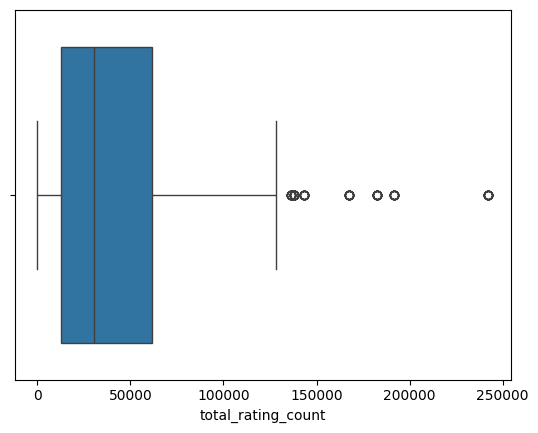

In [35]:
# Sample ข้อมูล แล้ว collect มาก่อน แทน toPandas() ตรง ๆ
sample_data = df_cleaned.select("total_rating_count").sample(fraction=0.1, seed=42).limit(1000).collect()

# แปลงเป็น Pandas DataFrame ด้วยมือ
import pandas as pd

sample_df = pd.DataFrame(sample_data, columns=["total_rating_count"]) # แปลงเป็น pandas

# Plot ด้วย seaborn
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=sample_df, x="total_rating_count")
plt.show()


✅ สิ่งที่เห็นในกราฟ:

- เจอค่าที่ outlier อยู่หลายค่า

 ##### เลือกว่าจะจัดการ outlier อย่างไร

- สิ่งสำคัญต้องตรวจดูก่อนว่าค่าที่ outlier มันเป็นกรณีไหน

- กรณีที่ไม่จริง :

  - ❌ ตัดทิ้งเลย: ถ้ารู้ว่าเป็น noise หรือ error

  - 🔄 แทนที่ด้วย median/mean: ถ้าไม่อยากให้เสีย record ไป

  - ✅ ถ้าไม่แน่ใจ 100% แนะนำสร้าง flag ระบุว่าเป็น outlier เพื่อรอการตรวจสอบ

- กรณีที่เป็นจริง :

  - 🔄 ไม่ยุ่งกับมัน (Keep as-is) แค่ สร้าง flag ระบุว่าเป็น outlier

  - ✅ เก็บไว้แยกวิเคราะห์ต่างหากแยกดูเฉพาะกลุ่มที่เป็น outlier ด้วยอีกชุด

โดยฉันจะกำหนดให้ข้อมูลเป็นค่าจริง

- จะทำการสร้าง flag เพื่อระบุว่าค่าไหนเป็น outlier

In [36]:
df = df_cleaned.withColumn("is_outlier", F.when(
    (df_cleaned["total_rating_count"] < lower_bound) | 
    (df_cleaned["total_rating_count"] > upper_bound),
    True).otherwise(False)
)

In [37]:
df.show(5)

+----------+-------------------+--------+-------+--------------------+--------------------+--------------------+-------------+---------------+------------------+--------------------+--------------------+------+------------------+-----+---------------+----+----------+
|      date|          timestamp| user_id|book_id|             country|          book_title|       book_subtitle|  book_author|  book_narrator|     audio_runtime|      audiobook_type|          categories|rating|total_rating_count|price|conversion_rate|  id|is_outlier|
+----------+-------------------+--------+-------+--------------------+--------------------+--------------------+-------------+---------------+------------------+--------------------+--------------------+------+------------------+-----+---------------+----+----------+
|2021-05-01|2021-05-01 00:00:00|ad8eca41|   1584|            Portugal|        Sycamore Row|         No Subtitle| John Grisham|   Michael Beck|20 hrs and 46 mins|Unabridged Audiobook|Mystery, Thril

### 5. Feature Engineering / Transformation

ขั้นตอนนี้มีเป้าหมายเพื่อ ปรับปรุงคุณภาพของข้อมูล ให้เหมาะกับการวิเคราะห์หรือส่งต่อไปยังขั้นตอน downstream (เช่น ML หรือ Dashboard)

##### 5.1 สร้าง Price ราคา THB 

- ถ้าต้องการที่จะสร้าง col ที่เป็นหน่อย THB :

In [38]:
from pyspark.sql.functions import round

df = df.withColumn( "THB", round(col("price") * col("conversion_rate"), 2))

df.show(5)

+----------+-------------------+--------+-------+--------------------+--------------------+--------------------+-------------+---------------+------------------+--------------------+--------------------+------+------------------+-----+---------------+----+----------+------+
|      date|          timestamp| user_id|book_id|             country|          book_title|       book_subtitle|  book_author|  book_narrator|     audio_runtime|      audiobook_type|          categories|rating|total_rating_count|price|conversion_rate|  id|is_outlier|   THB|
+----------+-------------------+--------+-------+--------------------+--------------------+--------------------+-------------+---------------+------------------+--------------------+--------------------+------+------------------+-----+---------------+----+----------+------+
|2021-05-01|2021-05-01 00:00:00|ad8eca41|   1584|            Portugal|        Sycamore Row|         No Subtitle| John Grisham|   Michael Beck|20 hrs and 46 mins|Unabridged Aud

ลบ column ที่ไม่ได้ใช้งาน

In [39]:
df = df.drop("date", "id") # ลบ column ที่ไม่ต้องการ

df.printSchema()
df.show(5)

root
 |-- timestamp: timestamp (nullable = true)
 |-- user_id: string (nullable = true)
 |-- book_id: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- book_title: string (nullable = true)
 |-- book_subtitle: string (nullable = true)
 |-- book_author: string (nullable = true)
 |-- book_narrator: string (nullable = true)
 |-- audio_runtime: string (nullable = true)
 |-- audiobook_type: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- total_rating_count: integer (nullable = true)
 |-- price: float (nullable = true)
 |-- conversion_rate: double (nullable = true)
 |-- is_outlier: boolean (nullable = false)
 |-- THB: double (nullable = true)

+-------------------+--------+-------+--------------------+--------------------+--------------------+-------------+---------------+------------------+--------------------+--------------------+------+------------------+-----+---------------+----------+------+
|          tim

### 6. Save Transformed Data

- บันทึกข้อมูลหลังจาก transform แล้วเป็นไฟล์ CSV สำหรับนำไปใช้ในขั้นตอนถัดไป เช่น Load เข้า Data Warehouse

✅ Tips

- ใช้ lowercase + underscore ในชื่อไฟล์ (ไม่เว้นวรรค)

- อย่าลืม .csv และใส่ header=True

- ถ้าอยาก versioning ก็เพิ่มวันที่ เช่น _v1, _20240731

In [49]:
df.write.mode("overwrite").option("header", True).csv("../data/processed/book_revenue_cleaned.csv")

- ถ้าเป็น Spark บันทึก `.csv` จะถูกเขียนเป็นโฟลเดอร์พร้อมไฟล์หลายพาร์ท (`part-0000...csv`)

- ถ้าอยากรวมเป็นไฟล์เดียวไว้ใช้ภายหลังได้ด้วย Pandas หลังจาก `.toPandas()` แล้ว `.to_csv()` อีกครั้ง